In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import skew


In [3]:
# =================================================
# Import dataset
# =================================================
# Concatenate train and test (adding a flag) to
# factorize data preparation steps
train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\train.csv", index_col=0)
test = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\test.csv", index_col=0)
train['train_test'] = 1
test['train_test'] = 0
y = np.log(train['SalePrice'])
x = pd.concat([train.drop(['SalePrice'], axis=1), test], axis=0)

In [4]:
# =================================================
# Data preparation
# =================================================
# Cast categorical features
categorical_feats = x.columns[x.dtypes == 'object'].tolist()
for col in categorical_feats:
    x[col].fillna('No', inplace=True)
    x[col] = x[col].astype("category")

In [5]:
# Fill Nan with median for numerical features
nan_feats = x.columns[~(x.dtypes == 'object') & (x.isnull().any())].tolist()
for col in nan_feats:
    x[col].fillna(x[col].median(), inplace=True)

In [6]:
x.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,train_test
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,0,No,No,No,0,2,2008,WD,Normal,1
2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,0,No,No,No,0,5,2007,WD,Normal,1
3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,0,No,No,No,0,9,2008,WD,Normal,1
4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,0,No,No,No,0,2,2006,WD,Abnorml,1
5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,0,No,No,No,0,12,2008,WD,Normal,1


In [7]:
# Unskew feature
numeric_feats = x.columns[x.dtypes != "object"].tolist()
numeric_feats.remove('train_test')

In [8]:
# -- Method 1: Compulte log transformation
if False:
    skewed_feats = x[numeric_feats].apply(lambda c: skew(c.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    x[skewed_feats] = np.log1p(x[skewed_feats])

In [9]:
# -- Method 2: Rank (uniform dist)
if True:
    x[numeric_feats] = x[numeric_feats].rank()
# One-hot encoding
x_dummified = pd.get_dummies(x[categorical_feats])
for col in categorical_feats:
    del x[col]
x[x_dummified.columns] = x_dummified

In [10]:
# =================================================
# Grid search
# =================================================
# Search `alpha` regression parameters
x_train = x[x.train_test == 1]
lasso = linear_model.Lasso(max_iter=1e2, normalize=True)
alphas = np.logspace(-5, -3, 10)
scores = []
scores_std = []
for alpha in alphas:
    lasso.alpha = alpha
    this_scores = np.sqrt(-model_selection.cross_val_score(lasso, x_train, y, cv=5, scoring='mean_squared_error'))
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
print('Min value {} reached for alpha={}'.format(min(scores), alphas[scores.index(min(scores))]))
plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.savefig('lasso_lars.png')


C:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Sco

Min value 0.13895063072631095 reached for alpha=7.742636826811278e-05


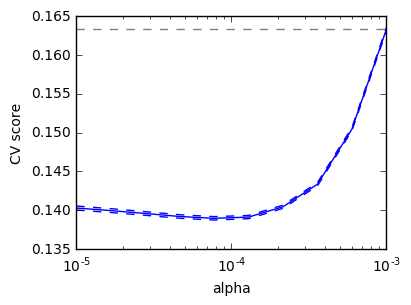

In [11]:
%matplotlib inline
plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(x_train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.savefig('lasso_lars.png')


In [12]:
# =================================================
# Train, apply & submit
# =================================================
lasso.alpha = 0.0001291549665014884
#lasso.alpha = 7.742636826811278e-05
lasso.fit(x_train, y) 
y_pred = lasso.predict(x[x.train_test == 0])
pd.DataFrame({'Id' : test.index, 'SalePrice': np.exp(y_pred)}).to_csv('submit_lasso.csv', index=False)
